The aim is to use a pretrained convnet to correctly classify 5 types of crop. Transfer learning is especially useful here as the pretrained model can extract useful features from the images, and the trainable part of the neural net can then extract some meaning from those features! Using this technique, we achieve a remarkable 97.5% accuracy on the test set.

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import keras
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

# Image Preprocessing

We first want to load and preprocess all the images with their correct labels. The only real preprocessing steps are to resize the image to be 224x224 (if necessary) and to scale the numbers in the array to be between 0 and 1.

In [2]:
# Load the images into a dataframe

df = []

crops = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']

# Useful dict for switching between crop names and labels
crop_to_label = {}
for i, crop in enumerate(crops):
    crop_to_label[crop] = i
    
label_to_crop = {value:key for (key, value) in crop_to_label.items()}

for crop in crops:
    subdir = '../input/agriculture-crop-images/kag2/' + crop
    for path in os.listdir(subdir):
        df.append([os.path.join(subdir, path), crop])
    
df = pd.DataFrame(df, columns=['path', 'label'])
df = df.sample(frac=1, random_state=0).reset_index(drop=True) # shuffle the rows
df.head()

,path,label
0,../input/agriculture-crop-images/kag2/sugarcan...,sugarcane
1,../input/agriculture-crop-images/kag2/wheat/wh...,wheat
2,../input/agriculture-crop-images/kag2/jute/jut...,jute
3,../input/agriculture-crop-images/kag2/sugarcan...,sugarcane
4,../input/agriculture-crop-images/kag2/wheat/wh...,wheat


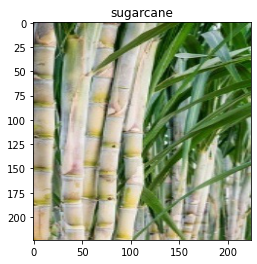

In [3]:
def preprocess_image(path):
    """Helper function to read, resize and rescale an image from its path"""
    im = plt.imread(path)
    im = cv2.resize(im, (224,224), interpolation=cv2.INTER_CUBIC)    
    return im/255.

# Test on first image in dataset
im = preprocess_image(df.loc[0, 'path'])
label = df.loc[0, 'label']

# Get the image dimensions to a variable
img_size, _, channels = im.shape

# Show the image with its label
plt.title(label)
plt.imshow(im)
plt.show()

We now preprocess all the images, and one-hot encode a label for them.

In [4]:
n_examples = len(df.index)
n_classes = len(crops)

# Initialize X and y
X = np.zeros(shape=(n_examples, img_size, img_size, channels))
y = np.zeros(shape=(n_examples, n_classes))

# Loop through dataset to set values of X and y
for i, idx in enumerate(df.index):
    path, label = df.loc[idx, :]
    X[i, :, :, :] = preprocess_image(path)
    y[i, crop_to_label[label]] = 1

Now, split X and y into train, and dev sets in proportions 80-20 respectively. We will then be ready to train a model.

In [5]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=0)

# Model Training

The model architecture consists of two hidden FC layers of size 1000 and 128 sitting on top of the VGG19 model, with a softmax layer to give the final prediction. 

In [6]:
num_classes = 5

model = Sequential()
vgg = VGG19(input_shape=(img_size,img_size,channels),include_top=False,weights = 'imagenet',pooling='avg')
model.add(vgg)
model.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

80142336/80134624 [==============================] - 1s 0us/step


**Hyperparameters to set:**

In [7]:
batch_size = 16
epochs = 30
learning_rate = 1e-3

We use an Adam optimizer, with a uniform learning rate decay.

In [8]:
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=learning_rate/epochs), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1000)              513000    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 20,666,157
Trainable params: 641,773
Non-trainable params: 20,024,384
_________________________________________________________________


Let's fit the model to our training data!

In [10]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size)

Epoch 1/30
40/40 [==============================] - 3s 86ms/step - loss: 1.5241 - accuracy: 0.3417 - val_loss: 1.3375 - val_accuracy: 0.4187
Epoch 2/30
40/40 [==============================] - 3s 67ms/step - loss: 1.1542 - accuracy: 0.5282 - val_loss: 1.3567 - val_accuracy: 0.4938
Epoch 3/30
40/40 [==============================] - 3s 66ms/step - loss: 0.9736 - accuracy: 0.6082 - val_loss: 1.0126 - val_accuracy: 0.5938
Epoch 4/30
40/40 [==============================] - 3s 66ms/step - loss: 0.8330 - accuracy: 0.6740 - val_loss: 0.9192 - val_accuracy: 0.5813
Epoch 5/30
40/40 [==============================] - 3s 66ms/step - loss: 0.7412 - accuracy: 0.7241 - val_loss: 0.6795 - val_accuracy: 0.7500
Epoch 6/30
40/40 [==============================] - 3s 66ms/step - loss: 0.5690 - accuracy: 0.7868 - val_loss: 0.7388 - val_accuracy: 0.6812
Epoch 7/30
40/40 [==============================] - 3s 66ms/step - loss: 0.4813 - accuracy: 0.8448 - val_loss: 0.6717 - val_accuracy: 0.6750
Epoch 8/30
40

# Model Evaluation

Let's first plot the loss and the accuracy over each epoch for the train and dev sets.

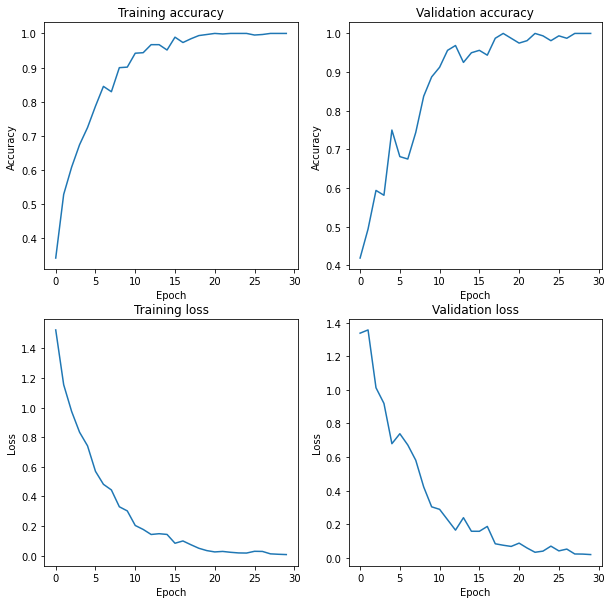

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])

plt.subplot(2, 2, 2)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'])

plt.subplot(2, 2, 3)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])

plt.subplot(2, 2, 4)
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['val_loss'])

plt.show()

The loss of both decreases and plateaus, which shows our model is fitting the data well.

In [12]:
test_df = pd.read_csv('../input/testssss/testdata.csv', index_col=0)

test_df.head()

,testpath,crop,croplabel
0,/kaggle/input/testssss/test_crop_image/wheat-f...,wheat,4
1,/kaggle/input/testssss/test_crop_image/jute-fi...,jute,0
2,/kaggle/input/testssss/test_crop_image/wheat-c...,wheat,4
3,/kaggle/input/testssss/test_crop_image/maize00...,maize,1
4,/kaggle/input/testssss/test_crop_image/rice-fi...,rice,2


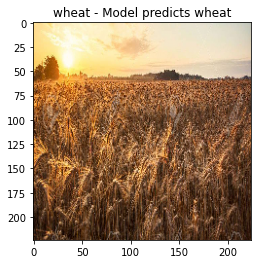

In [13]:
X_test = np.zeros(shape=(len(test_df.index), img_size, img_size, channels))
y_test = np.zeros(shape=(len(test_df.index), 5))

for i, idx in enumerate(test_df.index):
    path, crop = test_df.loc[idx, ['testpath', 'crop']]
    X_test[i, :, :, :] = preprocess_image(path)
    y_test[i, crop_to_label[crop]] = 1
    
plt.imshow(X_test[0, :, :, :])
plt.title(label_to_crop[np.argmax(y_test[0, :])] + ' - Model predicts ' + label_to_crop[model.predict_classes(np.array([X_test[0,:, :, :]]))[0]])
plt.show()

In [14]:
print('Test accuracy - {}%'.format(model.evaluate(X_test, y_test)[1] * 100))

2/2 [==============================] - 1s 290ms/step - loss: 1.8974 - accuracy: 0.6471
Test accuracy - 64.70588445663452%


Unfortunately, despite getting ~95-100% accuracy scores on the training and dev sets, its generalisation to new data is not as good. We see this also with some new images from the web.

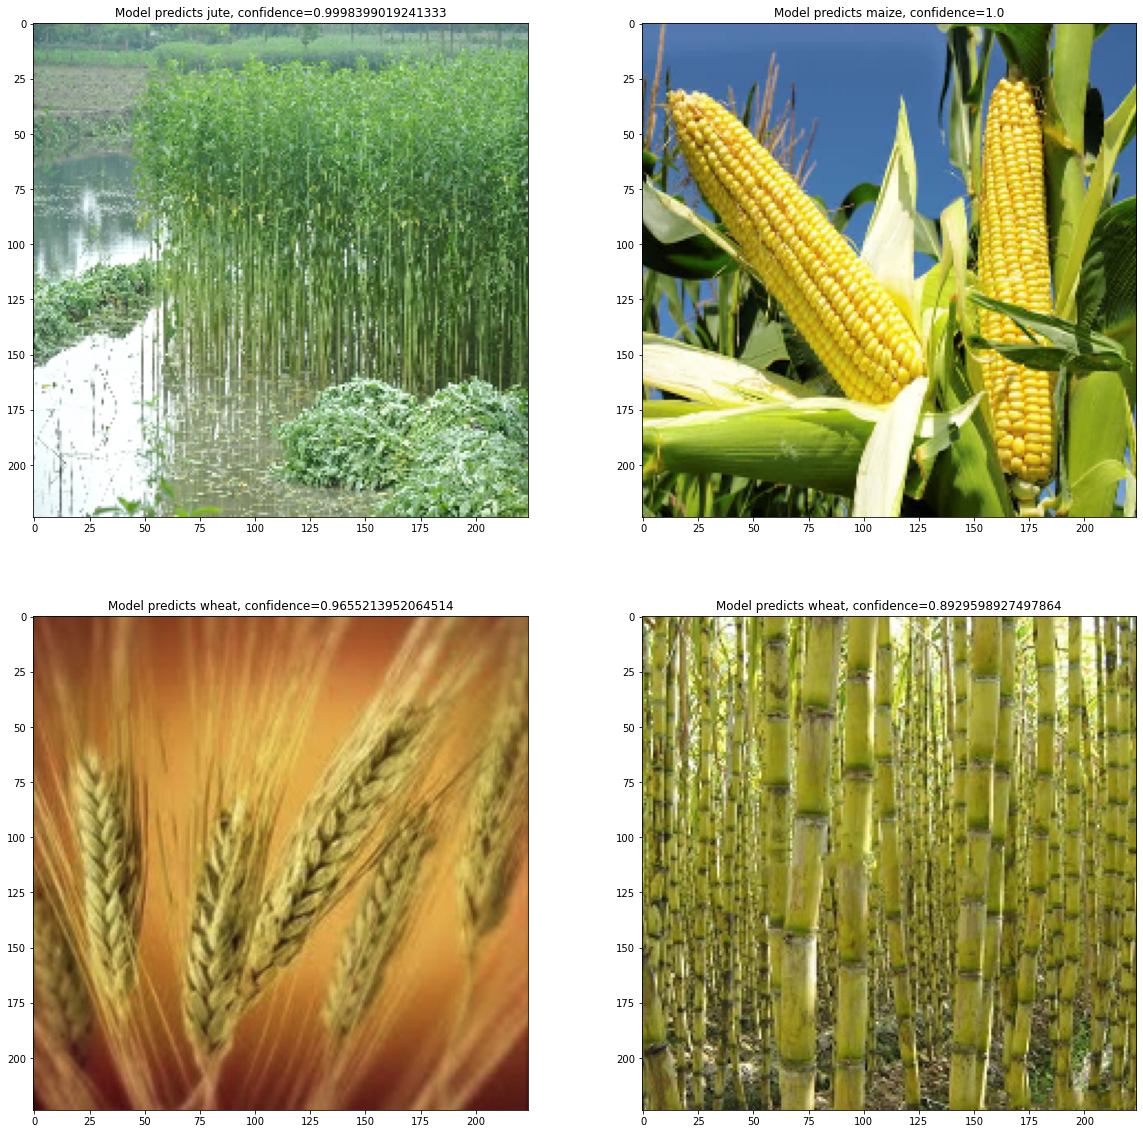

In [15]:
def model_predict(path):
    im = np.array([preprocess_image(path)])
    prediction = model.predict_classes(im)
    return np.vectorize(label_to_crop.get)(prediction)[0], model.predict(im)[0, prediction[0]]

plt.figure(figsize=(20, 20))

for n, path in enumerate(os.listdir('../input/new-images')): 
    prediction, confidence = model_predict('../input/new-images/' + path)
    plt.subplot(2, 2, n+1)
    plt.title('Model predicts {}, confidence={}'.format(prediction, confidence))
    plt.imshow(preprocess_image('../input/new-images/' + path))

The model correctly identifies three out of the four. The picture of the sugarcane here is quite different to the ones in the dataset, so we can see that our algorithm is unsure! In order to generalise well to new data, realistically we need a much bigger dataset. 

****PLEASE UPVOTE THIS NOTEBOOK IF YOU FOUND IT USEFUL!****

In [16]:
submission = pd.DataFrame(np.array([list(test_df['testpath'].values), list(model.predict_classes(X_test))]).T, columns=['pathname', 'label'])
submission.to_csv('submission.csv', index = False)